# Evaluation of nowcasts
Test the performance of current nowcasts using probabilistic scoring rules and standard accuracy measures and provide helpful visualisations of the weighted interval score (by component decomposition).

In [7]:
import numpy as np
import pandas as pd

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"

In [9]:
# Import own code from other directory
import sys
sys.path.append("../../code/evaluation")

from scoring import outside_interval, interval_score, weighted_interval_score, weighted_interval_score_fast, interval_consistency_score, mape_score, confidence_to_predictive

### Load ground truth

In [10]:
data_status = "2020-05-06"
truth_df = pd.read_pickle(f"../../data/processed/delay_{data_status}_imputation_01.pl")
truth_df = truth_df.groupby(["date_onset","imputed"]).size().reset_index().pivot(index="date_onset",columns="imputed",values=0).reset_index().fillna(0).rename(
    columns={"date_onset":"date",True:"count_imputed",False:"count_original"}).assign(count=lambda x:x.count_imputed+x.count_original)
truth_df.columns=list(truth_df.columns)

In [11]:
truth_df.head(5)

,date,count_original,count_imputed,count
0,2019-12-25,0.0,1.0,1.0
1,2019-12-26,0.0,1.0,1.0
2,2020-01-01,2.0,0.0,2.0
3,2020-01-06,1.0,0.0,1.0
4,2020-01-17,2.0,0.0,2.0


Limit to cases with date onset two weeks ago

In [12]:
truth_df = truth_df[truth_df["date"]<(pd.to_datetime(data_status)-pd.Timedelta(14,"days"))]

### Load predictions

In [13]:
qf_raw = pd.read_csv("../../data/nowcasted/nowcasting_matthias_05_12.csv",parse_dates=["date_from","date_for"])

Add fake data from earlier predictions to visualize comparison

In [14]:
qf_raw_fake = qf_raw.copy()
qf_raw_fake["date_from"]=pd.to_datetime("2020-05-05")
qf_raw_fake["lower_ci"]=np.round(qf_raw_fake["lower_ci"]*np.random.uniform(low=0.93, high=1.02, size=qf_raw_fake.shape[0]))
qf_raw_fake["upper_ci"]=np.round(qf_raw_fake["upper_ci"]*np.random.uniform(low=0.98, high=1.05, size=qf_raw_fake.shape[0]))
qf_raw_fake["point"]=np.round(qf_raw_fake["point"]*np.random.uniform(low=0.95, high=1.05, size=qf_raw_fake.shape[0]))
qf_raw = pd.concat([qf_raw,qf_raw_fake])
qf_raw = pd.concat([qf_raw[["date_from","date_for","point"]],
          pd.DataFrame(confidence_to_predictive(qf_raw["point"],qf_raw["lower_ci"],qf_raw["upper_ci"],alpha=0.025,quantiles=np.arange(0.05,1,0.05)),columns=np.arange(0.05,1,0.05).round(2),index=qf_raw.index)
          ],axis=1)

## Evaluate

In [15]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [16]:
qf=qf_raw.merge(truth_df,left_on="date_for",right_on="date").drop("date",axis=1)
qf["diff"] = qf["date_from"]-qf["date_for"]
all_quantiles = [col for col in qf.columns if isfloat(col)]

In [17]:
all_alphas = [float(col)*2 for col in qf.columns if (col in all_quantiles and float(col)<=0.5 and (1-float(col)) in qf.columns)]
all_alphas

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [18]:
quantile_dict = {float(col):qf[col].to_numpy() for col in qf.columns if col in all_quantiles}
observations = qf["count"].to_numpy()

### Interval score

In [19]:
is_total, is_sharpness, is_calibration = interval_score(observations, alpha=all_alphas[0], q_dict=quantile_dict)
i_score = pd.DataFrame(dict(date_from=qf["date_from"],date_for=qf["date_for"],diff=qf["diff"],total=is_total,sharpness=is_sharpness,calibration=is_calibration))
i_score.head(4)

,date_from,date_for,diff,total,sharpness,calibration
0,2020-05-12,2020-03-02,71 days,1068.837217,25.684754,1043.152463
1,2020-05-05,2020-03-02,64 days,1149.023264,27.886304,1121.136960
2,2020-05-12,2020-03-03,70 days,455.441868,24.950904,430.490964
3,2020-05-05,2020-03-03,63 days,328.279075,19.080103,309.198973


### Weighted interval score

In [20]:
# WIS^alpha score
wis_total, wis_sharpness, wis_calibration = weighted_interval_score_fast(observations, alphas=all_alphas, q_dict=quantile_dict, weights=None)
wis = pd.DataFrame(dict(date_from=qf["date_from"],date_for=qf["date_for"],diff=qf["diff"],total=wis_total,sharpness=wis_sharpness,calibration=wis_calibration))
wis.head(4)

,date_from,date_for,diff,total,sharpness,calibration
0,2020-05-12,2020-03-02,71 days,223.695653,6.546345,217.149308
1,2020-05-05,2020-03-02,64 days,240.791644,7.107461,233.684184
2,2020-05-12,2020-03-03,70 days,111.330323,6.359307,104.971016
3,2020-05-05,2020-03-03,63 days,81.498589,4.862999,76.635590


### Outside confidence interval count

In [21]:
outside = outside_interval(observations, quantile_dict[0.05], quantile_dict[0.95])
outs = pd.DataFrame(dict(date_from=qf["date_from"],date_for=qf["date_for"],diff=qf["diff"],outside=outside))
outs.groupby("outside").count()["date_for"]

outside
0    44
1    58
Name: date_for, dtype: int64

### Interval consistency score

In [22]:
qf_old = qf.query("date_from=='2020-05-05'")
qf_new = qf.query("date_from=='2020-05-12'")
interv_score = interval_consistency_score(qf_old[0.05].to_numpy(),qf_old[0.95].to_numpy(),qf_new[0.05].to_numpy(),qf_new[0.95].to_numpy())
ics = pd.DataFrame(dict(date_for=qf_new["date_for"],ics=interv_score))
ics["ics"].describe()

count     51.000000
mean      49.116381
std       49.065203
min        0.000000
25%        2.604653
50%       40.984497
75%       76.042638
max      217.966407
Name: ics, dtype: float64

# Summary

In [43]:
all_scores = pd.DataFrame(dict(date_from=qf["date_from"],
                  date_for=qf["date_for"],
                  diff=qf["diff"],
                  interval_score=is_total,
                  weighted_interval_score = wis_total,
                  outside_confidence=outside,
                 absolute_error=np.abs(qf["point"]-qf["count"]),
                 squared_error=np.square(qf["point"]-qf["count"]),
                mape_score=mape_score(qf["count"],qf["point"])))
all_scores.groupby("date_from").mean()

,interval_score,weighted_interval_score,outside_confidence,absolute_error,squared_error,mape_score
date_from,,,,,,
2020-05-05,736.160127,264.967823,0.568627,89.039216,12077.588235,3.633285
2020-05-12,792.733459,218.424227,0.647059,69.294118,7187.764706,3.187049


# Visualization

## Weighted Interval Score

In [23]:
wis = wis.sort_values(["date_for","date_from"],ascending=[True,True])

In [24]:
import plotly.express as px
import plotly.graph_objects as go

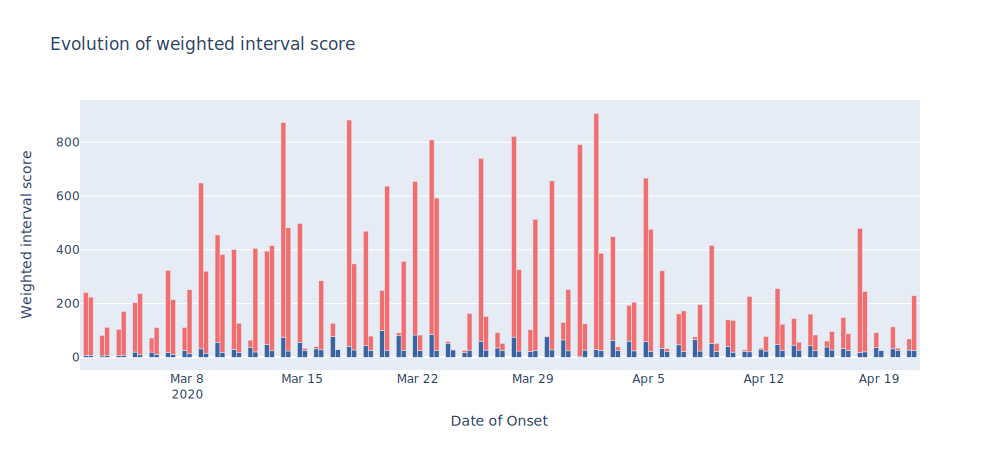

In [26]:
data = {
    "original":[15, 23, 32, 10, 23],
    "model_1": [4,   8, 18,  6,  0],
    "model_2": [11, 18, 18,  0,  20],
    "labels": [
        "feature",
        "question",
        "bug",
        "documentation",
        "maintenance"
    ]
}

wis_subsets = [wis.query(f"date_from=='{date}'") for date in wis["date_from"].unique()]

fig = go.Figure(
    data=[go.Bar(x = subset["date_for"].astype(str),y = subset["sharpness"], name="sharpness", marker=dict(color='#3a63a1'),
            offsetgroup=i) for i,subset in enumerate(wis_subsets)] + 
    [go.Bar(x = subset["date_for"].astype(str),y = subset["calibration"], name="calibration", marker=dict(color="#f26d6d"),
            offsetgroup=i,base=subset["sharpness"],customdata=subset["date_from"].dt.strftime("%B %d, %Y"),hovertemplate="From: %{customdata}<br>For:    %{x}<br>Sharpness: %{y}") for i,subset in enumerate(wis_subsets)],
    
    layout=go.Layout(
        title="Issue Types - Original and Models",
        yaxis_title="Number of Issues"
    )
)
fig.update_layout(title="Evolution of weighted interval score",showlegend=False,
                  xaxis=dict(title="Date of Onset"),
                 yaxis=dict(title="Weighted interval score"),bargap=0.4)

fig.show(renderer="svg", width=1000)

## Interval accuracy and outside interval counts

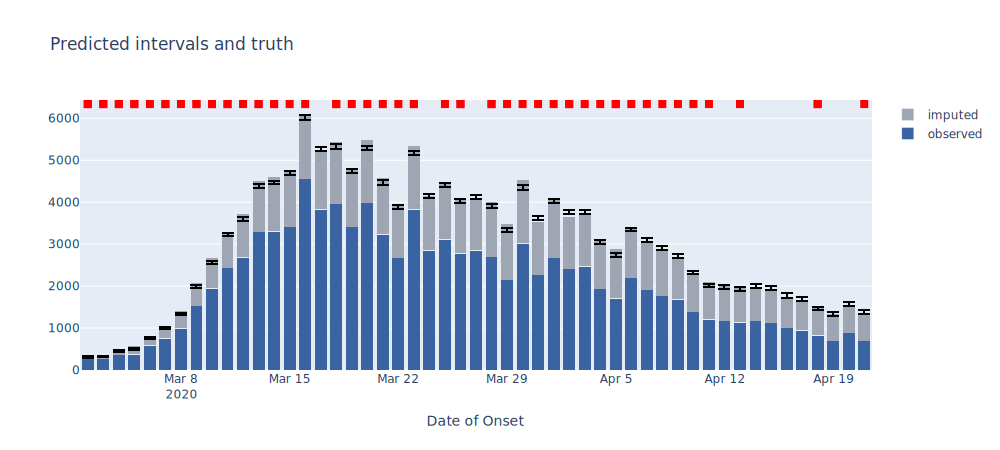

In [27]:
qf_p = qf.query("date_from=='2020-05-12'").sort_values("date_for")
#px.bar(qf_p,x="date_for",y="count")

alpha_val = 0.1

lower = float(alpha_val/2)
upper = float(1-(alpha_val/2))

fig = go.Figure()
fig.add_trace(go.Bar(
    x=qf_p["date_for"], y=qf_p["count_original"],
    name="observed",hovertemplate=None,marker=dict(color='#3a63a1')
))

fig.add_trace(go.Bar(
    x=qf_p["date_for"], y=qf_p["count_imputed"],marker=dict(color="#9fa6b3"),
    error_y=dict(type='data',
            symmetric=False,
            array=qf_p[upper]-qf_p["count"],
            arrayminus=qf_p["count"]-qf_p[lower],thickness=2,width=6,color='black')
    ,name="imputed",customdata = qf_p.to_numpy(),hovertemplate="%{x}, Imputed: %{customdata[6]}<br>Total: %{customdata[7]}, Interval: %{customdata[3]}-%{customdata[4]}"
))
fig.update_layout(title="Predicted intervals and truth",barmode="stack",xaxis=dict(title="Date of Onset"))

for k,v in outs.iterrows():
    if v["outside"]==1:
        fig.add_shape(dict(type="line",yref="paper",x0=v["date_for"],y0=0.97,x1=v["date_for"],y1=1,line=dict(color="red",width=8)))

fig.show(renderer="svg", width=1000)

## Interval consistency

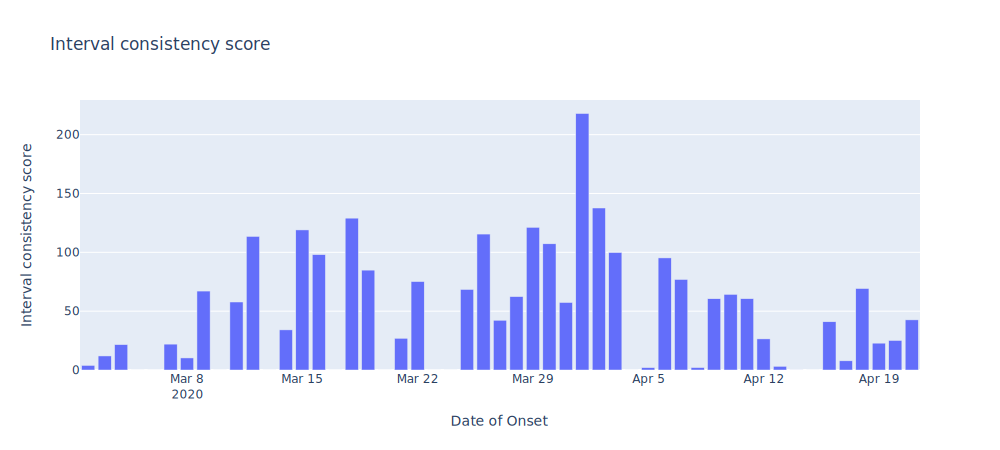

In [28]:
px.bar(ics, x = "date_for", y="ics", title="Interval consistency score", labels = {"date_for":"Date of Onset","ics":"Interval consistency score"}).show(renderer="svg",width=1000)